# Data for calibration


**Table of contents**<a id='toc0_'></a>    
- 1. [Download data](#toc1_)    
- 2. [National account](#toc2_)    
- 3. [Capital, employment and population](#toc3_)    
- 4. [Unemployment rate](#toc4_)    
- 5. [Steady state - aggregate](#toc5_)    
  - 5.1. [Save to disc](#toc5_1_)    
- 6. [Income and wealth over life-cycle](#toc6_)    
- 7. [Life-cyle profile of income](#toc7_)    
  - 7.1. [Predicted vs. observed income in year](#toc7_1_)    
  - 7.2. [Save to disc](#toc7_2_)    
  - 7.3. [Predicted vs. observed income for cohort 1983](#toc7_3_)    
- 8. [Wealth-income ratio:](#toc8_)    
  - 8.1. [Save to disc](#toc8_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import warnings

import numpy as np
import pandas as pd
import pickle

import statsmodels.api as sm # pip install statsmodels
from linearmodels import PanelOLS # pip install linearmodels
from IPython.display import display

from dstapi import DstApi # the helper class. pip install git+https://github.com/alemartinello/dstapi

import matplotlib.pyplot as plt   
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

## 1. <a id='toc1_'></a>[Download data](#toc0_)

In [2]:
NationalAccounts = DstApi('NAN1')        # Unit : current prices, bill. DKK
EmploymentPopuplation = DstApi('NAHB')   # Unit : total number of people
PopulationAge   = DstApi('BEFOLK1')      # Unit: total number of people by age
Unemployment = DstApi('AULAAR')          # Unit : % of labour force
Capital = DstApi('NABK10')               # Unit : current prices, bill. DKK

Income = DstApi('INDKP201')              # Unit : fixed and current prices, DKK
Wealth = DstApi('FORMUE11')              # Unit : current prices, DKK / Using 2014-defintion of net-wealth

FirstYear = 2000                         # Define first year of data (in cases where prior data exists)

In [3]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model
par = model.par # unpack model parameters

## 2. <a id='toc2_'></a>[National accounts](#toc0_)

In [4]:
display(NationalAccounts.tablesummary(language='en'))
# display(NationalAccounts.variable_levels('PRISENHED', language='en'))
# display(NationalAccounts.variable_levels('TRANSAKT', language='en'))

Table NAN1: Demand and supply by transaction, price unit and time
Last update: 2023-06-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,31,B1GQK,B.1*g Gross domestic product,EMPM_DC,"Total employment (1,000 persons)",False
1,PRISENHED,6,V_M,"Current prices, (bill. DKK.)",LAN_C,"Pr. capita, 2010-prices, chained values, (1000...",False
2,Tid,57,1966,1966,2022,2022,True


**Create dataframe:**

In [5]:
params = {
    'table': 'NAN1',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TRANSAKT', 'values': ['B1GQK','P7K','P6D','P31S1MD','P3S13D','P5GD']},    # variables of interest
        {'code': 'PRISENHED', 'values': ['V_M']},                                           # current prices
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}                                      # specified years    
        ]
    }
SupplyBalanceVar = NationalAccounts.get_data(params=params).set_index(['TID']).sort_values(['TID'])

In [6]:
# a. components of GDP
C = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.31 Private consumption'].apply(pd.to_numeric)
Y = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'B.1*g Gross domestic product'].apply(pd.to_numeric)
M = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.7 Imports of goods and services'].apply(pd.to_numeric)
X = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.6 Exports of goods and services'].apply(pd.to_numeric)
G = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.3 Government consumption expenditure'].apply(pd.to_numeric)
I = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.5g Gross capital formation'].apply(pd.to_numeric)

# b. ratio of each component to GDP
SupplyBalanceDF = pd.DataFrame()
SupplyBalanceDF['M_ratio'] = M/Y
SupplyBalanceDF['X_ratio'] = X/Y
SupplyBalanceDF['C_ratio'] = C/Y
SupplyBalanceDF['G_ratio'] = G/Y
SupplyBalanceDF['I_ratio'] = I/Y

display(SupplyBalanceDF.head())

,M_ratio,X_ratio,C_ratio,G_ratio,I_ratio
TID,,,,,
2000,0.381792,0.448866,0.470646,0.238752,0.223529
2001,0.384542,0.455997,0.467080,0.243237,0.218228
2002,0.388924,0.457420,0.469333,0.248670,0.213430
2003,0.370824,0.438753,0.472439,0.250348,0.209215
2004,0.383134,0.439641,0.477224,0.249336,0.216932


## 3. <a id='toc3_'></a>[Capital, employment and population](#toc0_)

**Employment and population:**

In [7]:
display(EmploymentPopuplation.tablesummary())
display(EmploymentPopuplation.variable_levels('SOCIO', language='en'))

Table NAHB: Beskæftigelse og befolkning efter socioøkonomisk status og tid
Last update: 2023-06-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,SOCIO,3,EMPM_DC,Samlet antal beskæftigede (antal),POP,Gennemsnitsbefolkning,False
1,Tid,57,1966,1966,2022,2022,True


,id,text
0,EMPM_DC,Samlet antal beskæftigede (antal)
1,EMPM_NC,Beskæftigede med bopæl i Danmark
2,POP,Gennemsnitsbefolkning


In [8]:
params = {
    'table': 'NAHB',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'SOCIO', 'values': ['EMPM_DC','POP']},     # variables of interest
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}      # specified years
        ]
    }
EmploymentPopuplationVar = EmploymentPopuplation.get_data(params=params).sort_values(['TID'])

**Population older than 22 but younger than 78:**

In [9]:
display(PopulationAge.tablesummary())

Table BEFOLK1: Befolkningen 1. januar efter køn, alder, civilstand og tid
Last update: 2023-03-01T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KØN,3,TOT,I alt,2,Kvinder,False
1,ALDER,101,TOT,Alder i alt,99-,99 år og derover,False
2,CIVILSTAND,5,TOT,I alt,F,Fraskilt,False
3,Tid,53,1971,1971,2023,2023,True


In [10]:
params = {
    'table': 'BEFOLK1',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'KØN', 'values': ['TOT']},
        {'code': 'ALDER', 'values': [f'>={par.age_ini}<={par.age_ini+par.life_span}']},     # variables of interest
        {'code': 'CIVILSTAND', 'values': ['TOT']},
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}      # specified years
        ]
    }
PopulationAgeVar = PopulationAge.get_data(params=params)
display(PopulationAgeVar.head())

,KØN,ALDER,CIVILSTAND,TID,INDHOLD
0,Total,22 years,Total,2001,66342
1,Total,23 years,Total,2001,66431
2,Total,24 years,Total,2001,69752
3,Total,25 years,Total,2001,76210
4,Total,26 years,Total,2001,75418


**Capital:**

In [11]:
display(Capital.tablesummary(language='en'))
# display(Capital.variable_levels('BEHOLD', language='en'))
# display(Capital.variable_levels('AKTIV', language='en'))

Table NABK10: Accumulation account and balance sheets, fixed assets (10a3-grouping) by stock / flow, assets, industry, price unit and time
Last update: 2023-06-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BEHOLD,9,LSN,"AN.11 Fixed assets, net capital stock, opening...",LEG,"Fixed assets, gross capital stock, closing bal...",False
1,AKTIV,8,N11,Fixed assets,N117,Intellectual property products,False
2,BRANCHE,15,V,Total,VR_S,"R_S Arts, entertainment and other services",False
3,PRISENHED,2,V,Current prices,LAN,"2010-prices, chained values",False
4,Tid,57,1966,1966,2022,2022,True


In [12]:
params = {
    'table': 'NABK10',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'BEHOLD', 'values': ['LSG']},          # gross capital => before depreciation
        {'code': 'AKTIV', 'values': ['N11']},           # fixed assets
        {'code': 'BRANCHE', 'values': ['V']},           # total level
        {'code': 'PRISENHED', 'values': ['V']},         # current prices
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}  # specified years    
        ]
    }
CapitalVar = Capital.get_data(params=params).sort_values(['TID'])

**Create dataframe:**

In [13]:
# a. employment and population
L = EmploymentPopuplationVar[['TID','INDHOLD']].loc[EmploymentPopuplationVar['SOCIO'] == 'Employment (number)'].copy().set_index(['TID']).apply(pd.to_numeric)
N_all = EmploymentPopuplationVar[['TID','INDHOLD']].loc[EmploymentPopuplationVar['SOCIO'] == 'Population'].copy().set_index(['TID']).apply(pd.to_numeric)
N_adult = PopulationAgeVar[['TID','INDHOLD']].copy().groupby('TID').sum()
K = CapitalVar[['TID','INDHOLD']].copy().set_index(['TID']).apply(pd.to_numeric)


# b. capital and employment ratio
CapitalEmploymentPopuplationDF = pd.DataFrame()
CapitalEmploymentPopuplationDF['K_ratio'] = K/Y/1000
CapitalEmploymentPopuplationDF['L_ratio'] = L/N_adult

display(CapitalEmploymentPopuplationDF.head(20))


,K_ratio,L_ratio
TID,,
2000,5.233344,0.744882
2001,5.253046,0.750498
2002,5.398142,0.749064
2003,5.459494,0.741013
2004,5.400718,0.736863
2005,5.304156,0.746910
2006,5.223147,0.763028
2007,5.433788,0.779278
2008,5.530440,0.785027


## 4. <a id='toc4_'></a>[Unemployment rate](#toc0_)

In [14]:
params = {
    'table': 'AULAAR',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'KØN', 'values': ['TOT']},                # men and women in total
        {'code': 'PERPCT', 'values': ['L10']},             # percent of the labour force 
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}      # specified years
        ]
    }
UnemploymentVar = Unemployment.get_data(params=params).set_index(['TID']).sort_values(['TID'])

In [15]:
UnemploymentDF = pd.DataFrame()
UnemploymentDF['U'] = UnemploymentVar[['INDHOLD']].loc[UnemploymentVar['PERPCT'] == 'Per cent of the labour force'].copy()
UnemploymentDF = UnemploymentDF.apply(pd.to_numeric)

display(UnemploymentDF.head())

,U
TID,
2000,4.9
2001,4.7
2002,4.8
2003,5.8
2004,5.8


## 5. <a id='toc5_'></a>[Steady state - aggregate](#toc0_)

In [16]:
frames = [SupplyBalanceDF, CapitalEmploymentPopuplationDF, UnemploymentDF]

In [17]:
all_variables =  pd.concat(frames, axis=1)
display(all_variables.head())

,M_ratio,X_ratio,C_ratio,G_ratio,I_ratio,K_ratio,L_ratio,U
TID,,,,,,,,
2000,0.381792,0.448866,0.470646,0.238752,0.223529,5.233344,0.744882,4.9
2001,0.384542,0.455997,0.467080,0.243237,0.218228,5.253046,0.750498,4.7
2002,0.388924,0.457420,0.469333,0.248670,0.213430,5.398142,0.749064,4.8
2003,0.370824,0.438753,0.472439,0.250348,0.209215,5.459494,0.741013,5.8
2004,0.383134,0.439641,0.477224,0.249336,0.216932,5.400718,0.736863,5.8


### 5.1. <a id='toc5_1_'></a>[Save to disc](#toc0_)

In [18]:
# a. aggregate steady state values
ss_aggregate = {}
means = all_variables.mean()
for i,mean in enumerate(means):
    print(f'{means.index[i]}: {mean:.2f}')
    ss_aggregate[str(means.index[i])] = mean

# b. save to dsic
with open('data/ss_aggregate.pickle', 'wb') as fp:
    pickle.dump(ss_aggregate, fp)

M_ratio: 0.46
X_ratio: 0.52
C_ratio: 0.47
G_ratio: 0.25
I_ratio: 0.22
K_ratio: 5.44
L_ratio: 0.74
U: 3.93


## 6. <a id='toc6_'></a>[Income and wealth over life-cycle](#toc0_)

**Income:**

In [19]:
Income.tablesummary(language='en')

Table INDKP201: Main table for personal income statistics by type of income, sex, age, population, price unit, unit and time
Last update: 2023-09-18T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,INDKOMSTTYPE,39,100,1 Disposable income (2+30-31-32-35),290,Taxable income,False
1,KOEN,3,MOK,"Men and women, total",K,Women,False
2,ALDER,15,14TOT,"Total, 15 years and over",80-00,80 years and over,False
3,POPU,2,5000,All regardless of having the type of income,5020,Only people with the type of income,False
4,PRISENHED,2,005,Constant prices,006,Nominal prices,False
5,ENHED,5,0050,Mean (DKK),105,People (Number),False
6,Tid,27,1996,1996,2022,2022,True


**Income in fixed prices (for income profile):**

In [20]:
params = {
    'table': 'INDKP201',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'INDKOMSTTYPE', 'values': ['100']},                        # disposable income (pre-tax income is 105) 
        {'code': 'KOEN', 'values': ['MOK']},                                # men and women in total
        {'code': 'ALDER', 'values': ['*']},	                                # all ages
        {'code': 'POPU', 'values': ['5000']},	                            # all regardless of having the type of income
        {'code': 'PRISENHED', 'values': ['005']},                           # fixed prices
        {'code': 'ENHED', 'values': ['0050']},                              # average DKK
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}
        ]
    }
DisposableIncomeVar = Income.get_data(params=params).sort_values(['TID'])
DisposableIncomeVar = DisposableIncomeVar[DisposableIncomeVar['INDHOLD'] != 0]

**Income in nominal prices (for wealth-income ratio):**

In [21]:
params = {
    'table': 'INDKP201',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'INDKOMSTTYPE', 'values': ['100']},                        # disposable income (pre-tax income is 105) 
        {'code': 'KOEN', 'values': ['MOK']},                                # men and women in total
        {'code': 'ALDER', 'values': ['*']},	                                # all ages
        {'code': 'POPU', 'values': ['5000']},	                            # all regardless of having the type of income
        {'code': 'PRISENHED', 'values': ['006']},                           # current prices
        {'code': 'ENHED', 'values': ['0050']},                              # average DKK
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}
        ]
    }
DisposableIncomeVar_cprice = Income.get_data(params=params).sort_values(['TID']) # cprice = current prices
DisposableIncomeVar_cprice = DisposableIncomeVar_cprice[DisposableIncomeVar_cprice['INDHOLD'] != 0]

**Wealth:**

In [22]:
Wealth.tablesummary(language='en')

Table FORMUE11: Wealth by type of wealth, unit, age, sex, population and time
Last update: 2022-12-20T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,FORM1,46,FGNF2020,"Net Wealth, (2020-definition A+B+CX-D-E-F)",FGF4,F.4. Other debt to the public sector,False
1,ENHED,9,200,Median (Constant prices 2021-level),240,Number of people in population 31.12,False
2,ALDER,16,1802,18 years and over,9099,90 years and over,False
3,KØN,3,MOK,"Men and women, total",K,Women,False
4,POPU,2,5005,Entire population,5025,Only people with the selected type of wealth,False
5,Tid,8,2014,2014,2021,2021,True


In [23]:
display(Wealth.variable_levels('ENHED', language='en'))

,id,text
0,200,Median (Constant prices 2021-level)
1,205,Lower quartile (Constant prices 2021-leel)
2,210,Upper quartile (Constant prices 2021-level)
3,215,Average (Constant prices 2021-level)
4,220,Median (Nominal prices)
5,225,Lower quartile (Nominal prices)
6,230,Upper quartile (Nominal prices)
7,235,Average (Nominal prices)
8,240,Number of people in population 31.12


In [24]:
params = {
    'table': 'FORMUE11',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'FORM1', 'values': ['FGNF2014']},              # net wealth (2014 definition)
        {'code': 'ENHED', 'values': ['235']},                   # current prices
        {'code': 'ALDER', 'values': ['*']},	                    # all ages
        {'code': 'KØN', 'values': ['MOK']},                     # men and women
        {'code': 'POPU', 'values': ['5005']},	                # entire population	
        {'code': 'Tid', 'values':[f'>=2014<']}                  # first year for the data set is 2014
        ]
    }
WealthVar = Wealth.get_data(params=params).sort_values(['TID'])

**Create dataframes:**

In [25]:
# a. income data - current prices
IncomeDF_cprice = pd.crosstab(index=[DisposableIncomeVar_cprice['TID']],
                              values = DisposableIncomeVar_cprice['INDHOLD'], 
                              aggfunc = sum, columns = str('DisInc: ') + DisposableIncomeVar_cprice['ALDER'])  # convert unique ages as columns for income

# b. income data - fixed prices
IncomeDF = pd.crosstab(index=[DisposableIncomeVar['TID']],
                       values = DisposableIncomeVar['INDHOLD'], 
                       aggfunc = sum, columns = str('DisInc: ') + DisposableIncomeVar['ALDER'])  # convert unique ages as columns for income

# c. wealth data - current prices
WealthDF = pd.crosstab(index=[WealthVar['TID']],
                       values = WealthVar['INDHOLD'], 
                       aggfunc = sum, columns = str('Wealth: ') + WealthVar['ALDER']) # convert unique ages as columns for wealth

IncomeWealthDF =  pd.concat([IncomeDF,WealthDF], axis=1)                # concatenate dataframes - fixed prices
IncomeWealthDF_cprice =  pd.concat([IncomeDF_cprice,WealthDF], axis=1)  # concatenate dataframes - current prices

## 7. <a id='toc7_'></a>[Life-cyle profile of income](#toc0_)

**Set up data for regression:**

In [26]:
# a. log income for regression
log_IncomeDF = np.log(IncomeDF)

# b. drop total income column
log_IncomeDF.drop('DisInc: Total, 15 years and over', axis=1, inplace=True)

# c. rename columns
col_dict = {f'DisInc: {i}-{i+4} years' : f'age{i}-{i+4}' for i in range(15,75+1,5)}
log_IncomeDF = log_IncomeDF.rename(columns = {'DisInc: 80 years and over':'age80>='})
log_IncomeDF.rename(columns = col_dict, inplace=True)

**Long format:**

In [27]:
log_IncomeDF = log_IncomeDF.reset_index()
long_df = pd.melt(log_IncomeDF, id_vars="TID", var_name="age_group", value_name="log_income")

**Add variables:**
- Age 
- Birth year
- Age squared  

In [28]:
# new variables
long_df['median_birth_year'] = 0
long_df['median_age_squared'] = 0
long_df['median_age'] = 0
long_df['id'] = 0

a = range(0,308+22,22)
b = range(17,82+5,5)

# the age of a group is the median age of that group, i.e. 17 for group age15-19
for i,j in zip(a,b):
    long_df.loc[i:i+22,['median_birth_year']] = long_df['TID'] - j
    long_df.loc[i:i+22,['median_age_squared']] = j**2
    long_df.loc[i:i+22,['median_age']] = j
    long_df.loc[i:i+22,['id']] = j

long_df.set_index(['id', 'TID'], inplace=True)

**Run regression:**

In [29]:
# dependent variable
dependent = long_df.log_income

# exogenous variables
exog = sm.add_constant(long_df[['median_birth_year','median_age_squared','median_age']])

In [30]:
mod = PanelOLS(dependent, exog, drop_absorbed=True)
res = mod.fit(cov_type='unadjusted')
res

Dep. Variable:,log_income,R-squared:,0.7842
Estimator:,PanelOLS,R-squared (Between):,0.7893
No. Observations:,308,R-squared (Within):,0.6605
Date:,"Mon, Sep 18 2023",R-squared (Overall):,0.7842
Time:,10:12:21,Log-likelihood,-10.148
Cov. Estimator:,Unadjusted,,
,,F-statistic:,368.16
Entities:,14,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(3,304)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,368.16


### 7.1. <a id='toc7_1_'></a>[Predicted vs. observed income in year](#toc0_)

In [31]:
year = 2010 # must be a year in the data, i.e. 2000-2021

**Predicted income:**

In [32]:
pred_income = []
age = []

# loop over years with income
for i in range(15,82+1):
    age.append(i)
    pred_income.append(np.exp((year-i)*res.params.median_birth_year + 
                              res.params.const + 
                              res.params.median_age*i + 
                              res.params.median_age_squared*i**2))

**Observed income:**

In [33]:
warnings.filterwarnings('ignore')

obs_income = long_df.loc[long_df.index.get_level_values(1) == year, :]
obs_income['income'] = np.exp(obs_income['log_income'])
display(obs_income)

warnings.filterwarnings('default')

,,age_group,log_income,median_birth_year,median_age_squared,median_age,income
id,TID,,,,,,
17,2010,age15-19,10.534759,1993,289,17,37600.0
22,2010,age20-24,11.776827,1988,484,22,130200.0
27,2010,age25-29,12.183827,1983,729,27,195600.0
32,2010,age30-34,12.449803,1978,1024,32,255200.0
37,2010,age35-39,12.581766,1973,1369,37,291200.0
42,2010,age40-44,12.635580,1968,1764,42,307300.0
47,2010,age45-49,12.643359,1963,2209,47,309700.0
52,2010,age50-54,12.630032,1958,2704,52,305600.0
57,2010,age55-59,12.607195,1953,3249,57,298700.0


**Plot:**

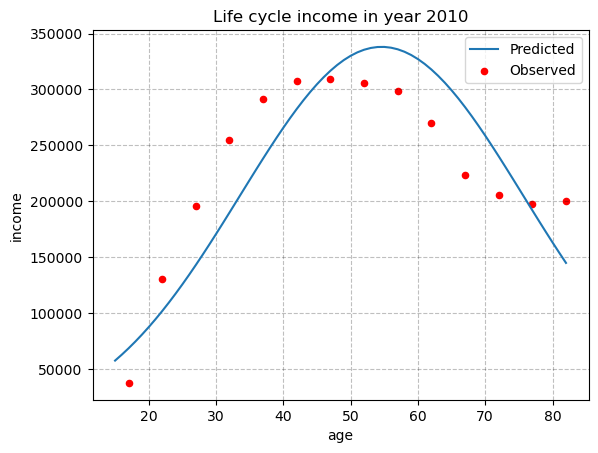

In [34]:
plt.plot(age, pred_income, label='Predicted')
obs_income.plot(kind='scatter', x='median_age', y='income', label='Observed', color='red', ax=plt.gca())

plt.title('Life cycle income in year ' + str(year))
plt.ylabel('income')
plt.xlabel('age')
plt.legend()
plt.show()

### 7.2. <a id='toc7_2_'></a>[Save to disc](#toc0_)

In [35]:
## a. household income
ss_households_income = {}
ss_households_income['age'] = obs_income['median_age'].to_numpy()[1:13] # drop the first element and last element
ss_households_income['income'] = obs_income['income'].to_numpy()[1:13] # drop the first element and last element
ss_households_income['income'] /= ss_households_income['income'][0] # normalization

# b. save to disc
with open('data/ss_households_income.pickle', 'wb') as f:
    pickle.dump(ss_households_income, f)

### 7.3. <a id='toc7_3_'></a>[Predicted vs. observed income for cohort 1983](#toc0_)

**Predicted income for cohort 1983:**

In [36]:
pred_income = []
age = []

# loop over years with income
for i in range(15,82+1):
    age.append(i)
    pred_income.append(np.exp((1983)*res.params.median_birth_year + 
                              res.params.const + 
                              res.params.median_age*i + 
                              res.params.median_age_squared*i**2)) # birth year, 1983, remains constant

**Observed income for cohort 1983:**

In [37]:
warnings.filterwarnings('ignore')

obs_income = long_df.loc[long_df['median_birth_year'] == 1983, :]
obs_income['income'] = np.exp(obs_income['log_income'])
display(obs_income)

warnings.filterwarnings('default')

,,age_group,log_income,median_birth_year,median_age_squared,median_age,income
id,TID,,,,,,
17,2000,age15-19,10.594132,1983,289,17,39900.0
22,2005,age20-24,11.795092,1983,484,22,132600.0
27,2010,age25-29,12.183827,1983,729,27,195600.0
32,2015,age30-34,12.443908,1983,1024,32,253700.0
37,2020,age35-39,12.697715,1983,1369,37,327000.0


**Plot:**

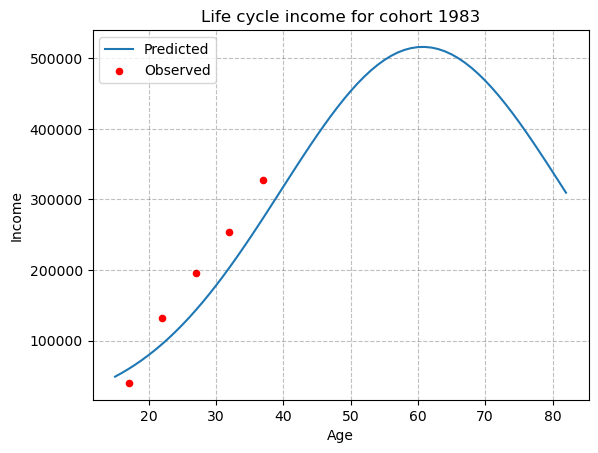

In [38]:
plt.plot(age, pred_income, label='Predicted')
obs_income.plot(kind='scatter', x='median_age', y='income', label='Observed', color='red', ax=plt.gca())

plt.title('Life cycle income for cohort 1983')
plt.ylabel('Income')
plt.xlabel('Age')
plt.legend()
plt.show()

## 8. <a id='toc8_'></a>[Wealth-income ratio:](#toc0_)

**Calculate the wealth-income ratio based on the raw data:**

In [39]:
# a. get the relevant data frame
IncomeWealthDF =  pd.concat([IncomeDF_cprice,WealthDF], axis=1)

ages = []

# b. loop over age groups common to income and wealth data
for i in range(25,75+1,5):
    IncomeWealthDF['age_'+str(i)+'-'+str(i+4)] = IncomeWealthDF['Wealth: '+str(i)+'-'+str(i+4)+' years']/IncomeWealthDF['DisInc: '+str(i)+'-'+str(i+4)+' years']
    ages.append(i+2)

# c. the first age group, age_15-24. Assuming no wealth for 15-17 years - no data ...
IncomeWealthDF['age_20-24'] = IncomeWealthDF['Wealth: 18-24 years']/IncomeWealthDF['DisInc: 20-24 years']
ages = [22] + ages

# d. wealth-income ratio for all age groups
IncomeWealthDF = IncomeWealthDF[['age_' + str(i) + '-' + str(i+4) for i in range(20,75+1,5)]]
IncomeWealthDF = IncomeWealthDF.dropna() # drop NANs - wealth data only available for 2014-2021

# e. take the mean over time for each age group
wealth_income_ratio = IncomeWealthDF.mean()
print(wealth_income_ratio)

ALDER
age_20-24     0.766505
age_25-29     0.890354
age_30-34     1.353119
age_35-39     2.105508
age_40-44     3.002049
age_45-49     3.944616
age_50-54     5.090512
age_55-59     6.610468
age_60-64     8.626078
age_65-69    10.807956
age_70-74    10.705477
age_75-79     9.617599
dtype: float64


**Linear interpolation of the observed wealth-income ratio:**

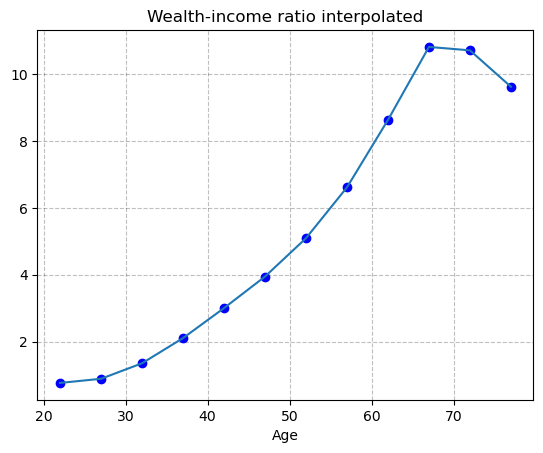

In [40]:
wealth_income_ratio_list = wealth_income_ratio.tolist()

ages_ = min(ages) + np.arange(max(ages)-min(ages)+1)
wealth_inc_interp = np.interp(ages_,ages,wealth_income_ratio_list)

plt.title('Wealth-income ratio interpolated')
plt.plot(ages,wealth_income_ratio_list,'bo')
plt.plot(ages_,wealth_inc_interp)
plt.xlabel('Age')
plt.show()

### 8.1. <a id='toc8_1_'></a>[Save to disc](#toc0_)

In [41]:
## a. household income
ss_households_wealth = {}
ss_households_wealth['age'] = ages_[2:]
ss_households_wealth['wealth_income_ratio'] = wealth_inc_interp[2:]

# b. save to disc
with open('data/ss_households_wealth.pickle', 'wb') as f:
    pickle.dump(ss_households_wealth, f)